## Entraîner un classifieur via transfer learning

Nous allons adapter un classifieur pré-entraîné à nos nouvelles données. 

Les images que nous allons utiliser sont issues d'une [compétition de la plateforme Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview). Cette compétition, datant de 2013, a été remportée par un français, Pierre Sermanet (qui travaille maintenant pour Google Brain), qui a obtenu une précision de 98.9% en utilisant un réseau de neurones convolutionnel. Cependant, comme nous n'allons considérer ici qu'un petit sous-ensemble de ces données, nous n'aurons probablement qu'une précision beaucoup plus faible. 

## Imports <a class="anchor" id="imports"></a>
Nous commençons par importer les paquets nécessaires pour ce notebook. 

La commande ```%matplotlib inline``` permet d'afficher les graphiques de matplotlib avec la bibliothèque graphique intégrée à Notebook. Sans cette commande, les graphiques générés avec ```matplotlib```ne s'afficheront pas. 

Le bibliothèque suivantes sont importées :
- La bibliothèque ```OpenCV```, qui s'importe avec la commande ```import cv2```, nous servira à lire et à prétraiter les images avant qu'elles n'entrent dans le classifieur ;
- ```Matplotlib``` est utilisée pour afficher des images et tracer des courbes ;
- ```Numpy``` sert à faire des calculs matriciels.  Les images lues par ```OpenCV``` sont stockées comme des matrices ```Numpy``` ;
- ```Os``` permet d'utiliser des fonctionnalités dépendantes du système d'exploitation, comme créer des dossiers, ou spécifier des chemins à partir de noms de dossiers ;
- ```Random``` permet de générer des nombres aléatoires. Nous nous en servirons pour initialiser les paramètres du classifieur ;
- La bibliothèque ```Scikit-Learn```, qui s'importe avec la commande ```import sklearn```, contient une grande quantité d'outils pour l'apprentissage automatique. Cette librairie nécessite d'importer individuellement tous les sous-paquets qui seront utilisés. Dans ce notebook, nous l'utiliserons pour calculer diverses métriques permettant d'évaluer la performance de notre classifieur, nous importons donc son sous-paquet ```metrics```. Nous l'utiliserons également pour séparer les données en sous-ensembles d'entraînement, validation et test, avec le sous-paquet ```model_selection``` ;
- La bibliothèque ```TensorFlow``` et son module ```Keras``` nous permettront de créer et d'entraîner le réseau de neurones. 

In [26]:
# Imports
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras

Ce notebook a été créé avec les versions de paquets suivantes :

In [27]:
print("Version d'OpenCV", cv2.__version__)
print("Version de Numpy", np.__version__)
print("Version de Scikit-Learn", sklearn.__version__)
print("Version de Pandas", pd.__version__)
print("Version de TensorFlow", tf.__version__)
print("Version de Keras", keras.__version__)

Version d'OpenCV 4.6.0
Version de Numpy 1.23.4
Version de Scikit-Learn 1.1.2
Version de Pandas 1.5.0
Version de TensorFlow 2.6.0
Version de Keras 2.6.0


Certains de ces paquets sont installés par défaut à l'installation de Python. D'autres doivent être installés séparément. 

Si l'import d'un de ces paquets échoue en renvoyant un message d'erreur spécifiant ```ModuleNotFoundError```, c'est probablement que le paquet n'a pas été installé. Dans ce cas, installez le paquet manquant en exécutant la commande ```!pip install <paquet manquant>```.

La cellule qui suit installe tous les paquets nécessaires à ce notebook. Commentez les lignes correspondant aux paquets qui sont déjà installés, exécutez la cellule pour installer les paquets restants, et exécutez à nouveau la cellule effectuant l'import des modules nécessaires. 

In [ ]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install keras

## Création d'ensembles de données <a class="anchor" id="donnees"></a>

Nous allons commencer par charger l'ensemble des données. 

Une fois les données pour l'entraînement et les tests sélectionnées, nous aurons besoin d'uniformiser leurs tailles avant de les utiliser. 

Nous ne leur appliquerons pas d'autre traitement : chaque réseau pré-entraîné attend des images différentes en entrée (images en niveaux de gris ou avec trois canaux de couleur, intensités comprises entre 0 et 1 o entre -1 et 1, etc.). 

Nous leur appliquerons donc un prétraitement supplémentaire uniquement après avoir choisi un réseau préentraîné en particulier. 

### Pré-traitement des images <a class="anchor" id="pretraitement"></a>

Chacune de ces images a une taille différente. 

Nous allons donc harmoniser leurs tailles. 

Notons que nous pouvons choisir n'importe quelle taille pour nos images d'entrée. En effet, seules les couches complètement connectées requièrent une taille d'entrée fixée, les couches de convolution sont indépendantes de la taille des images d'entrée. Pour ré-entraîner un réseau, nous allons justement supprimer toutes ses couches complètement connectées, et ne conserver que les couches de convolution. Nous pouvons donc choisir la taille d'images que nous voulons. 

Ici, et comme dans le notebook précédent, nous allons utiliser des images de taille 128 x 128. Pour des raisons d'efficacité des calculs, les tailles choisies en entrée sont souvent des puissances de 2.

Nous allons tout d'abord créer une fonction qui redimensionne une image individuelle. 

Pour cela, nous définissons une fonction, ```resize_images_in_folder```, qui prend en entrée le chemin vers une image. Cette image est lue et redimensionnée. 

Nous allons appliquer un redimensionnement simple, qui modifiera le ratio hauteur/largeur de la plupart des images. Il est possible que ceci affecte légèrement la performance de la classification, mais, comme c'est la manière la plus simple de redimensionner une image, c'est généralement celle qui est appliquée lors des premiers tests.

Libre à vous de faire ensuite des expériences avec des images de tailles plus grandes ou plus petites, ainsi qu'avec des redimensionnements qui permettent de conserver le ratio hauteur/largeur des images. 

In [3]:
# Données
root_dir = 'donnees'
img_dir = 'dataset1'
label_filename = 'labels_dataset1.csv'

In [4]:
img_size = 128

In [5]:
def resize_image(input_image_path, output_image_size):
    # On lit l'image
    image_content = cv2.imread(input_image_path)
    # On vérifie que l'image peut être lue.
    if image_content is None:
        print("could not read image ", input_image_path)
        return image_content
    else:
        # On la redimensionne
        square_image = cv2.resize(image_content, (output_image_size, output_image_size))

        return square_image

Commençons par appliquer cette fonction à une image pour voir exactement ce qu'elle fait. 

Nous choisissons une image au hasard du dossier, affichons sa taille et ses intensités min et max. 

In [22]:
# Sélection d'une image dans le dosser Cat
train_dir = os.path.join(root_dir, img_dir)
img_name = os.listdir(train_dir)[0]
img_path = os.path.join(train_dir, img_name)
original_img = cv2.imread(img_path)
print("Taille de l'image originale :", original_img.shape)
print("Intensités min et max de l'image originale :", np.min(original_img), np.max(original_img))

Taille de l'image originale : (224, 320, 3)
Intensités min et max de l'image originale : 0 255


Si l'instruction ci-dessus ne fonctionne pas, il peut être nécessaire de changer votre répertoire courant, ou le chemin vers le dossier ```root_dir```. 

L'instruction ```%pwd``` vous permet d'afficher le répertoire courant ; ```%cd``` de le modifier.

Nous appliquons ensuite la fonction ```resize_image``` à cette image, et affichons sa taille pour vérifier que le redimensionnement fonctionne bien. 

In [23]:
# Conversion de l'image grâce à notre fonction grayscale_and_resize_image
processed_img = resize_image(img_path, img_size)
print("Taille de l'image prétraitée :", processed_img.shape)

Taille de l'image prétraitée : (128, 128, 3)


Affichons maintenant ces deux images. 

Notons que ```OpenCV``` lisant les images en utilisant les canaux de couleur dans l'ordre (B, G, R), il est nécessaire de remettre les canaux dans l'ordre habituel (R, G, B) avant de les afficher avec ```matplotlib```.

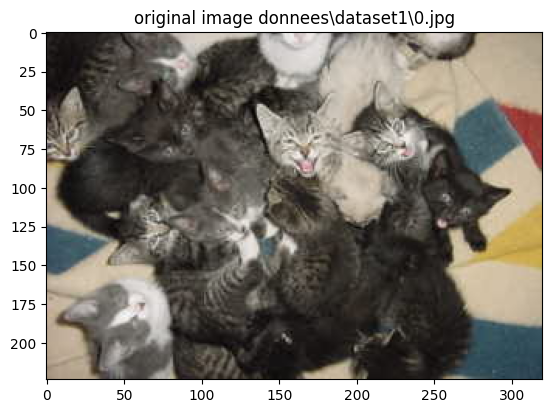

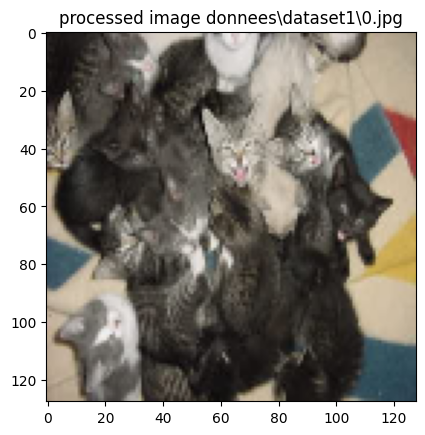

In [24]:
# Affichage de l'image originale
rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) # Changement d'ordre des canaux de couleur
# Affichage avec matplotlib
plt.imshow(rgb_img)
plt.title("original image " + img_path)
plt.show()

# Affichage de l'image convertie
rgb_processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB) # Changement d'ordre des canaux de couleur
plt.imshow(rgb_processed_img) 
plt.title("processed image " + img_path)
plt.show()

### Construction des données d'entraînement, validation et test <a class="anchor" id="selection"></a>

Nous allons directement créer les matrices d'images et d'étiquettes qui seront utilisées par le modèle. Ceci nous permettra d'utiliser la fonction ```train_test_split``` de la librairie ```sklearn```. 

Après avoir lu les étiquettes, la première étape est de construire des matrices X et y contenant toutes les images prétraitées et les étiquettes. Nous utiliserons ensuite la fonction ```train_test_split``` pour les séparer en images à utiliser pour l'entraînement, la validation et les tests. 

La **matrice X** contient toutes les images. Elle est de dimension nombre d'images * hauteur * largeur * nombre de canaux. 

La **matrice y** contient les caractéristiques de chaque image. Nous allons représenter chaque caractéristique par un vecteur de taille 2 : (1, 0) pour les chats, et (0, 1) pour les chiens. Cette représentation, nommée "encodage à chaud" ("one hot encoding" en anglais), est fréquemment utilisée en apprentissage automatique. Cette matrice est de dimensions nombre d'images * nombre de classes.

In [47]:
# On initialise la liste X_list, qui contiendra chaque image sous forme d'un vecteur unidimensionnel,
# et la liste y, qui contiendra chaque étiquette sous forme d'un entier égal à 0 ou 1
X_list = []
y_list = []

labels = pd.read_csv(os.path.join(root_dir, label_filename))

# On considère chacune des images successivement
for img_name in os.listdir(os.path.join(root_dir, img_dir)):
    # On récupère le chemin vers l'image
    img_path = os.path.join(root_dir, img_dir, img_name)
    # On modifie sa taille
    square_image = resize_image(img_path, img_size)
    # On récupère son étiquette
    image_label = labels[labels['image_name']==img_name]['label'].item()
    if image_label == "Cat":
        class_id = 1
    else:
        class_id = 0

    # Si l'image est valide, on l'ajoute aux listes
    if square_image is not None:
        # On l'ajoute à la liste
        X_list.append(square_image)
        y_list.append(class_id)
                    
# On convertit X_liste depuis une liste de vecteurs en une matrice numpy
X = np.stack(X_list, axis=0)

# On encode y_tuple avec un encodage à chaud.
y = np.asarray(y_list)
y = np.stack([y, 1-y], axis=-1)

In [48]:
##### Vérification des dimensions de X et de y
print("X.shape", X.shape)
print("y.shape", y.shape)

X.shape (100, 128, 128, 3)
y.shape (100, 2)


On peut maintenant utiliser la fonction ```train_test_split``` de la librairie ```sklearn```. 

Cette fonction permet de séparer une matrice d'images et la matrice d'étiquettes correspondante en deux ensembles de données, dans une proportion donnée en argument. Les arguments obligatoire de la fonction sont les suivants :
- matrice contenant les images,
- matrice ou vecteur contenant les étiquettes.

Il est également possible de spécifier plusieurs arguments optionnels :
- ```test_size``` : proportion de données à utiliser dans le second ensemble de données,
-  ```shuffle``` : ce booléen détermine s'il faut, ou non, mélanger les données avant de les séparer en deux groupes. Par défaut, il est mis à ```True```,
- ```random_state``` : ce paramètre permet d'initialiser le générateur de nombre aléatoires d'une manière reproductible, ce qui permet d'obtenir le même résultat lorsqu'on exécute plusieurs fois la fonction,
- ```stratify``` : si cet argument vaut ```None``` (ce qui est la valeur par défaut), alors les données sont séparées de manière aléatoire. Si on donne la liste des étiquettes comme valeur à cet argument, les données seront séparées de manière stratifiées, c'est à dire que chaque ensemble de données contiendra la même proportion d'images de chacune des classes.

La fonction ```train_test_split``` ne permettant de séparer un ensemble de données qu'en deux parties, nous l'exécutons deux fois :
- une première fois pour séparer les images *entraînement + validation* des images de *test*, avec une proportion de 80% pour le premier ensemble et 20% pour le second,
- une deuxième fois pour séparer les images *entraînement + validation* renvoyées par la première exécution en images d'*entraînement* et images de *validation*, avec encore une fois une proportion de 80% pour le premier ensemble et 20% pour le second.

In [49]:
# Séparation des images en train + val et test
X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(X, y, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42,
                                                                                    stratify=y)

In [50]:
# Affichage des dimensions des matrices créées
print("X_train_val.shape", X_train_val.shape)
print("y_train_val.shape", y_train_val.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train_val.shape (80, 128, 128, 3)
y_train_val.shape (80, 2)
X_test.shape (20, 128, 128, 3)
y_test.shape (20, 2)


L'ensemble "entraînement + validation" contient 80% des 100 images de départ, soit 80 images. La matrice X_train_val a donc effectivement pour taille nombre d'images * hauteur * largeur * nombre de canaux, i.e. 80 * 128 * 128 * 1. 

Les étiquettes étant encodées à chaud, la matrice y_train_val a pour taille nombre d'images * nombre de classes, i.e. 80 * 2.

L'ensemble de test contient 20% des 100 images de départ, soit 20 images. La matrice X_test a donc effectivement pour taille nombre d'images * hauteur * largeur * nombre de canaux, i.e. 20 * 128 * 128 * 1. 

Les étiquettes étant encodées à chaud, la matrice y_test a pour taille nombre d'images * nombre de classes, i.e. 132 * 2.

In [51]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape)
print("y_val.shape", y_val.shape)

X_train.shape (64, 128, 128, 3)
y_train.shape (64, 2)
X_val.shape (16, 128, 128, 3)
y_val.shape (16, 2)


## Choisir et charger un modèle <a class="anchor" id="modele"></a>

```Keras``` propose plusieurs modèles préentraînés sur ImageNet. Un modèle préentraîné est composé de deux parties : l'architecture du modèle, et les poids. Les fichiers de poids étant très lourds, ils ne sont pas directement inclus dans Keras, mais sont téléchargés lors de l'instanciation d'un modèle préentraîné. 

Les modèles suivants sont disponibles : 
- ```VGG16``` ;
- ```InceptionV3``` ;
- ```ResNet``` ;
- ```MobileNet``` ;
- ```Xception``` ;
- ```InceptionResNetV2```.

Tous ces réseaux sont entraînés sur ImageNet, ils sont donc entraînés à prédire l'appartenance d'une image à une classe parmi les 1000 classes de la base de données. La dernière couche de chacun de ces réseaux est une couche complètement connectée contenant 1000 neurones. 

Afin d'adapter ces réseaux pour notre usage, nous allons charger toutes les couches, sauf la dernière couche complètement connectée. Nous remplacerons cette dernière par une couche complètement connecté à deux neurones, car nous avons deux classes. 

Dans ce notebook, nous allons utiliser le réseau ```InceptionV3```.

Commençons par charger ce réseau, afin de visualiser son architecture. 

Pour cela, nous utilisons la fonction ```keras.applications.inception_v3.InceptionV3```, qui accepte les arguments suivants :
- ```weights``` : si cet argument est ```imagenet``` (ce qui est la valeur par défaut), alors les poids du réseau préentraîné sur ImageNet sont chargés. Si cet argument est ```None```, alors les poids sont initialisés aléatoirement. On peut aussi charger d'autres poids, on donnant le chemin vers ces poids dans cet argument ;
- le booléen ```include_top``` vaut ```True``` si la dernière couche complètement connectée du réseau doit être chargée, ```False``` sinon. Notons que si la dernière couche est chargée (c'est alors le réseau dans sa totalité qui est chargé), ceci impacte les entrées et les sorties du réseau : les images d'entrée doivent obligatoirement avoir la taille prévue par le réseau, et la sortie sera un vecteur de 1000 éléments.
- l'argument ```input_shape```, qui permet de spécifier la taille des images d'entrée, ne doit être utilisé que si l'argument ```include_top``` vaut ```False```. 

Commençons par charger et visualiser le réseau entier. 

In [19]:
# Chargement et visualisation du réseau entier
inception_model_top = keras.applications.inception_v3.InceptionV3(weights='imagenet', 
    include_top=True)

# Visualisation de l'architecture du réseau
print(inception_model_top.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

On voit que la dernière couche, nommé ```predictions (Dense) ``` donne en sortie un vecteur de 1000 éléments. 

Chargeons maintenant le modèle sans cette dernière couche, afin de voir la différence. 

In [21]:
# Chargement et visualisation du réseau sans la dernière couche
inception_model = keras.applications.inception_v3.InceptionV3(weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)

# Visualisation de l'architecture du réseau
print(inception_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 63, 63, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 63, 63, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

Ce réseau a deux couches de moins que le réseau complet : il lui manque la toute dernière couche, complètement connectée, ainsi que l'avant-dernière couche, qui réalise une agrégation par la moyenne. 

A partir de ce réseau, recréons maintenant un réseau complet pour faire de la classification à deux classes. 

Pour cela, on commence par geler les poids de ce modèle. En effet, dans un premier temps, nous n'allons entraîner que les couches additionnelles. 

In [22]:
# Gel des poids du modèle de base inception_model
inception_model.trainable = False

Nous allons maintenant ajouter des couches à ce modèle. 

La première couche à créer est la couche d'entrée. Elle est créée grâce à la fonction ```keras.Input```, qui prend comme unique argument la taille des images. 

In [24]:
# Création de la couche d'entrée
inputs = keras.Input(shape=(img_size, img_size, 3))

Le réseau ```inception_model``` attend en entrée des images dont les intensités sont comprises entre -1 et 1. 

Nous faisons donc suivre la couche d'entrée d'une couche de prétraitement, qui va ajuster les intensités comme il convient. Cette couche utilise la fonction ```keras.layers.Rescaling```, qui prend deux arguments : 
- ```scale``` est un facteur multiplicatif à appliquer aux intensités, 
- ```offset``` est un facteur additif. 

L'intensité de chaque pixel en sortie de cette couche vaut : intensité_originale $\times$ ```scale``` + ```offset```

Afin d'obtenir des intensités entre -1 et 1 à partir d'intensités entre 0 et 255, nous utilisons les valeurs suivantes :
- ```scale```= 1/127.5
- ```offset``` = -1

La sortie de ce réseau est stockée dans la variable ```scaled_images```. 


In [26]:
# Couche de prétraitement pour ajuster les intensités
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
scaled_images = scale_layer(inputs)

Nous pouvons maintenant ajouter les couches suivantes :
- le **réseau de base** ```inception_model```, qui prend en entrée les images originales prétraitées stockées dans la variable ```scaled_images```. Comme ce réseau contient des couches de normalisation par lot, nous lui donnons comme argument ```training=False```. Le réseau est ainsi en mode "inférence", et ces couches ne seront pas modifiées. Ce réseau est stocké dans la variable ```inception``` ;
- une **couche d'agrégation par moyennage**, définie avec la fonction ```keras.layers.GlobalAveragePooling2D```. Cette fonction ne nécessite aucun argument. On l'applique à la sortie de la couche précédente, et on stocke la couche ainsi définie dans la variable ```average_pooling```;
- une **couche de dropout**, afin de limiter le suraprentissage. Cette couche est définie avec la fonction ```keras.layers.Dropout```, qui prend en argument la fraction de noeuds à désactiver à chaque époque. On choisit ici $0.2$. On l'applique à la sortie de la couche précédente, et on stocke cette couche dans la variable ```dropout```;
- une **couche complètement connectée**, avec deux neurones, définie avec la fonction ```keras.layers.Dense```. Cette fonction prend comme arguments le nombre de neurones, ici deux. On l'applique  à la sortie de la couche précédente, et on stocke cette couche dans la variable ```dense```;
- enfin, une couche **Softmax** permet de convertir les sorties de la couche complètement connectée en probabilités. Cette couche est créée avec la fonction ```tf.keras.layers.Softmax```, qui ne nécessite aucun argument en entrée. On l'applique  à la sortie de la couche précédente, et on stocke cette couche dans la variable ```outputs```. 

*Remarque : attention à ne pas confondre l'attribut ```trainable```, qu'on peut appliquer à un réseau entier ou à une seule couche pour signifier que ses poids doivent être optimisés pendant l'apprentissage, et l'attribut ```training```, qui ne s'applique qu'à un réseau entier et qui détermine si ce réseau fonctionne en mode "apprentissage" ou en mode "inférence".*

In [27]:
inception = inception_model(scaled_images, training=False)
average_pooling = keras.layers.GlobalAveragePooling2D()(inception)
dropout = keras.layers.Dropout(0.2)(average_pooling)
dense = keras.layers.Dense(2)(dropout)
outputs = tf.keras.layers.Softmax()(dense)

Nous pouvons maintenant créer un modèle à partir de toutes ces couches. 

La fonction ```Model``` de ```Keras``` prend deux arguments : la couche d'entrée, et la couche de sortie, et créé un modèle. 

In [28]:
model = keras.Model(inputs, outputs)

# Affichage du modèle créé
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0     

On voit que seule une petite partie des paramètres est définie comme étant entraînable. Les premières couches du réseau Inception sont donc bien considérées comme des couches non entraînables. 

## Entraînement du réseau <a class="anchor" id="entrainement"></a>

L'entraînement du réseau va se faire en deux étapes. 

On va commencer par entraîner seulement la dernière couche, i.e. la couche complètement connectée qu'on a ajoutée au réseau initial. On évaluera les performances du modèle après cette première étape. 

On entraînera ensuite toutes les couches du réseau, en utilisant un taux d'apprentissage très faible, et on évaluera à nouveau les performances du modèle pour voir ce que cette seconde étape a apporté. 

### Entraînement de la dernière couche <a class="anchor" id="dernierecouche"></a>

Lors de la création du modèle, nous avons déjà spécifié quelles couches devaient être entraînées. 
Nous pouvons maintenant entraîner le modèle comme d'habitude ; seuls les paramètres de la dernière couche complètement connectée seront optimisés.

Pour cela, il faut tout d'abord compiler le modèle, afin de spécifier des informations telles que :
- La fonction d'optimisation, 
- La fonction-coût, 
- D'éventuelles métriques additionnelles à enregistrer à chaque époque.

Ici, nous utilisons la fonction Adam pour l'optimisation, avec un taux d'apprentissage de $10^ -4$, et la fonction-coût d'entropie croisée binaire, qui est le choix le plus courant pour réaliser une classification binaire. 
En plus de la fonction-coût, nous demandons au réseau de calculer la précision à chaque époque. 

Après compilation, l'entraînement du modèle se fait en utilisant la fonction ```fit``` de Keras. Les paramètres de cette fonction sont :
- Les images de test,
- Les étiquettes de test,
- Le nombre d'époques pendant lequel réaliser l'entraînement, 
- La taille de lot à utiliser. 

Ici, nous allons entraîner le modèle pendant 20 époques, avec une taille de lot de 8. 

In [29]:
# Compilation du modèle
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

epochs = 20
history_step1 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=8)

Epoch 1/20
53/53 [==============================] - 11s 82ms/step - loss: 1.3186 - accuracy: 0.5948 - val_loss: 0.7139 - val_accuracy: 0.6698
Epoch 2/20
53/53 [==============================] - 1s 27ms/step - loss: 0.7335 - accuracy: 0.7417 - val_loss: 0.6135 - val_accuracy: 0.7547
Epoch 3/20
53/53 [==============================] - 1s 27ms/step - loss: 0.6208 - accuracy: 0.7915 - val_loss: 0.4950 - val_accuracy: 0.8019
Epoch 4/20
53/53 [==============================] - 1s 26ms/step - loss: 0.4901 - accuracy: 0.8223 - val_loss: 0.4657 - val_accuracy: 0.8113
Epoch 5/20
53/53 [==============================] - 1s 25ms/step - loss: 0.4411 - accuracy: 0.8555 - val_loss: 0.4401 - val_accuracy: 0.8302
Epoch 6/20
53/53 [==============================] - 1s 24ms/step - loss: 0.3331 - accuracy: 0.8815 - val_loss: 0.4236 - val_accuracy: 0.8491
Epoch 7/20
53/53 [==============================] - 1s 25ms/step - loss: 0.3517 - accuracy: 0.8626 - val_loss: 0.4132 - val_accuracy: 0.8491
Epoch 8/20
5

La fonction ```fit``` renvoie en sortie l'historique des métriques évaluées pendant le processus d'optimisation, sous la forme d'un dictionnaire. 

Commençons par afficher les différentes clefs sauvegardées. 

In [30]:
# Liste des données enregistrées dans l'historique d'optimisation
print(history_step1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


On a enregistré les valeurs de la fonction-coût et de la précision des données d'entraînement et de validation. 

On peut tracer ces valeurs en fonction du nombre d'itérations pour mieux visualiser l'entraînement. 

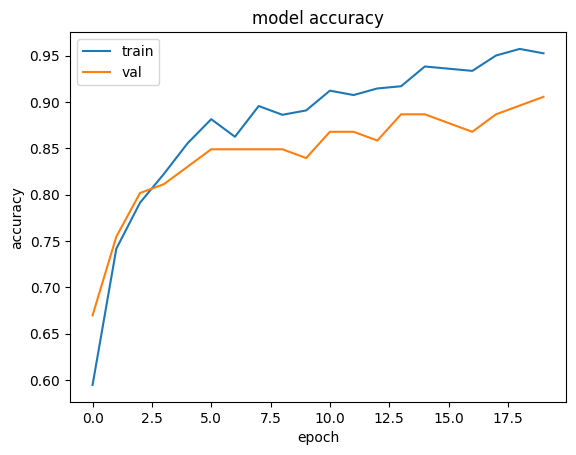

In [31]:
# Affichage de l'accuracy
plt.plot(history_step1.history['accuracy'])
plt.plot(history_step1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

La performance est systématiquement moins bonne sur les données de validation que sur les données d'entraînement, ce qui est attendu. 

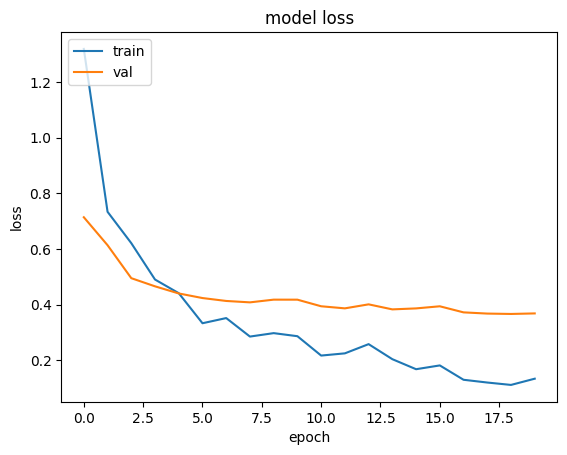

In [32]:
# Affichage de la fonction coût
plt.plot(history_step1.history['loss'])
plt.plot(history_step1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Au cours de itérations, la fonction-coût des deux ensembles de données, entraînement et validation, décroît.

### Evaluation du classifieur après entraînement de la dernière couche<a class="anchor" id="evalderniercouche"></a>

Nous pouvons maintenant calculer les valeurs de prévision, spécificité et score F1 pour les images de test, en utilisant la fonction ```classification_report``` de la bibliothèque ```sklearn```. 

Cette fonction nécessite que les étiquettes soient encodées au format binaire (0 pour les chiens et 1 pour les chats). Nous devons donc convertir les étiquettes prédites et réelles depuis le format à chaud vers ce format. Pour cela, nous utilisons la fonction ```argmax```de ```numpy```, qui appliquée à un vecteur, renvoie l'indice qui contient la valeur maximale. 

Par exemple, considérons un vecteur de prédiction $y = [0.67, 0.33]$, qui correspond à un chien avec l'encodage à chaud.

L'indice contenant la valeur maximale est l'indice 0, ce qui correspond bien à la classe du chien avec l'encodage au format binaire.

Nous calculerons également une matrice de confusion pour visualiser les résultats. 

In [33]:
# Calcul des prédictions pour les images contenues dans X_train
y_pred = model.predict(X_test)

# Conversion des prédictions et des étiquette réelles au format binaire 
y_pred_bin = np.argmax(y_pred, axis=-1)
y_test_bin = np.argmax(y_test, axis=-1)

# Calcul des métriques en utilisant la bibliothèque sklearn
print(sklearn.metrics.classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87        66
           1       0.88      0.86      0.87        66

    accuracy                           0.87       132
   macro avg       0.87      0.87      0.87       132
weighted avg       0.87      0.87      0.87       132



La bibliothèque ```sklearn``` a aussi une fonction qui permet de tracer la matrice de confusion. 

Il s'agit de la fonction ```ConfusionMatrixDisplay.from_predictions```, qui prend en entrée deux arguments obligatoires :
- une liste d'étiquettes réelles au format binaire ;
- une liste d'étiquettes prédites au format binaire. 

Cette fonction accepte également plusieurs arguments facultatifs. Ici, on précise une colormap bleue, qui est différente de celle choisie par défaut, mais conforme à la manière dont sont généralement affichées les matrices de confusion. 

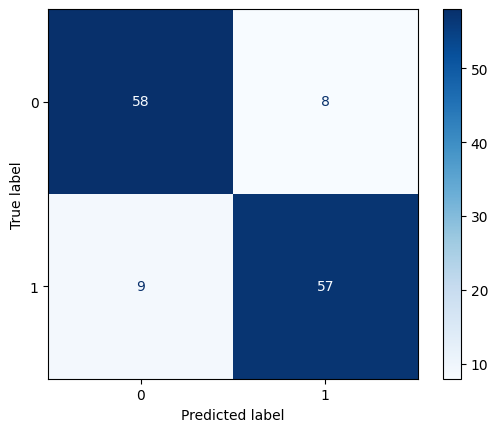

In [34]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test_bin, y_pred_bin, cmap='Blues')

Les résultats obtenus en réetraînant uniquement la dernière couche sont déjà très bons. Voyons si on peut encore les améliorer en réentraînant l'ensemble du modèle. 

### Entraînement de toutes les couches <a class="anchor" id="touteslescouches"></a>

Pour entraîner l'ensemble du modèle, nous devons spécifier que toutes les couches sont entraînables. 

Ceci se fait avec l'instruction suivante :

In [36]:
# Dégel du modèle de base
inception_model.trainable = True

*Remarque : Si nous le voulions, nous pourrions choisir de n'entraîner que les n dernières couches du réseau. L'attribut ```trainable``` peut également s'appliquer à une couche, plutôt qu'au réseau entier.*

Affichons la structure du modèle pour vérifier que toutes les couches sont bien entraînables. 

In [37]:
# Affichage de la structure du modèle
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0     

Le modèle contient plus de 21 000 000 paramètres entraînables, contre 4 098 à l'étape précédente. Les paramètre du modèle de base sont donc bien considérés comme des paramtères entraînables. 

Par contre, nous ne voulons pas mettre à jour les couches de normalisation par lot du réseau de base. En effet, il est important qu'elles gardent en mémoire les statistiques d'ImageNet. Comme nous avons spécifié ```training=False``` lors de sa création, il reste en mode "inférence", et ces couches ne seront pas modifiées. Nous n'avons rien à modifier de plus. 

Comme précédemment, nous pouvons maintenant compiler le modèle. C'est à cette étape que nous spécifions la fonction d'optimisation et le taux d'apprentissage utilisés. 

Ici, nous utilisons la fonction Adam pour l'optimisation, avec un taux d'apprentissage de $10^ -5$. Il est courant de choisir un taux d'apprentissage dix fois plus petit pour l'optimisation de l'ensemble du réseau que pour l'optimisation de la dernière couche seule. 

Après compilation, l'entraînement du modèle se fait en utilisant la fonction ```fit``` de Keras.

Ici, nous allons entraîner le modèle pendant 10 époques, avec une taille de lot de 8. 

In [38]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

epochs = 10
history_step2 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=8)

Epoch 1/10
53/53 [==============================] - 11s 102ms/step - loss: 0.2436 - accuracy: 0.9242 - val_loss: 0.3102 - val_accuracy: 0.9151
Epoch 2/10
53/53 [==============================] - 4s 71ms/step - loss: 0.0396 - accuracy: 0.9882 - val_loss: 0.3169 - val_accuracy: 0.9245
Epoch 3/10
53/53 [==============================] - 4s 72ms/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.3826 - val_accuracy: 0.9434
Epoch 4/10
53/53 [==============================] - 4s 67ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4050 - val_accuracy: 0.9434
Epoch 5/10
53/53 [==============================] - 4s 71ms/step - loss: 7.2120e-04 - accuracy: 1.0000 - val_loss: 0.4070 - val_accuracy: 0.9434
Epoch 6/10
53/53 [==============================] - 4s 70ms/step - loss: 9.5859e-04 - accuracy: 1.0000 - val_loss: 0.3910 - val_accuracy: 0.9434
Epoch 7/10
53/53 [==============================] - 4s 69ms/step - loss: 6.0401e-04 - accuracy: 1.0000 - val_loss: 0.3736 - val_accuracy: 0.9340

Affichons maintenant l'historique des valeurs d'accuracy et de fonction coût évaluées pendant le processus d'optimisation.

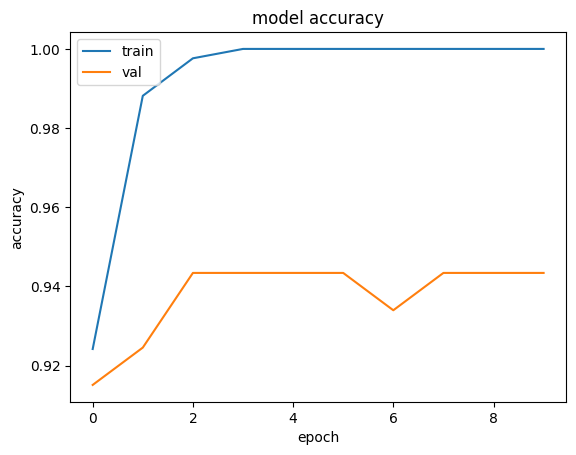

In [39]:
# Affichage de l'accuracy
plt.plot(history_step2.history['accuracy'])
plt.plot(history_step2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

La performance est systématiquement moins bonne sur les données de validation que sur les données d'entraînement, ce qui est attendu. 

Cependant, l'ampleur de l'écart nous indique que le réseau est probablement en situation de suraprentissage. 

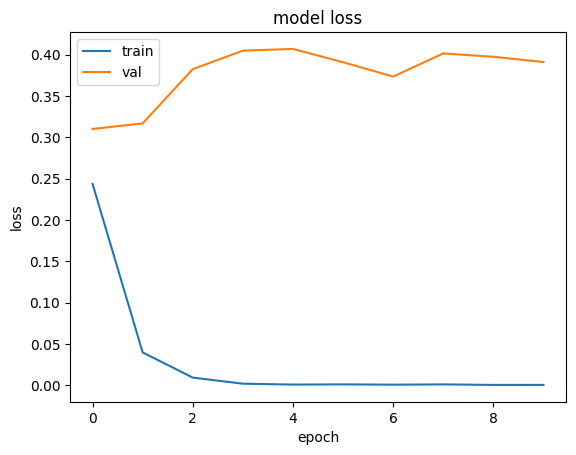

In [40]:
# Affichage de la fonction coût
plt.plot(history_step2.history['loss'])
plt.plot(history_step2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Au cours de itérations, la fonction-coût des données d'entraînement décroît, tandis que celle des données de validation croît : il y a donc du surapprentissage.

### Evaluation du classifieur après entraînement de toutes les couches <a class="anchor" id="evaltoutescouches"></a>

Nous pouvons maintenant calculer les valeurs de prévision, spécificité et score F1 pour les images de test, et calculer une matrice de confusion pour visualiser les résultats.

In [41]:
# Calcul des prédictions pour les images contenues dans X_test
y_pred = model.predict(X_test)

# Conversion des prédictions et des étiquette réelles au format binaire 
y_pred_bin = np.argmax(y_pred, axis=-1)
y_test_bin = np.argmax(y_test, axis=-1)

# Calcul des métriques en utilisant la bibliothèque sklearn
print(sklearn.metrics.classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        66
           1       0.95      0.86      0.90        66

    accuracy                           0.91       132
   macro avg       0.91      0.91      0.91       132
weighted avg       0.91      0.91      0.91       132



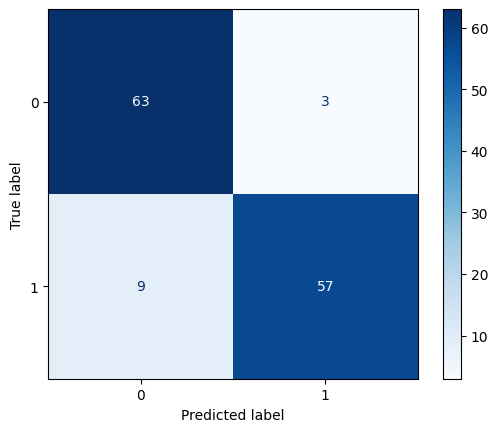

In [42]:
# Calcul et affichage de la matrice de confusion
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test_bin, y_pred_bin, cmap='Blues')

Malgré le surapprentissage, réentraîner toutes les couches du réseau a permis d'augmenter ses performances. 

Les résultats finaux sont très bons. Ceci s'explique par le fait que notre ensemble de données n'est pas très éloigné de la base de données sur laquelle est entraîné le réseau de base. En effet, ImageNet contient plusieurs classes d'espèces de chiens et de chats. Même avant son adaptation, notre réseau de base était donc déjà entraîné pour reconnaître des chats et des chiens. 

## Conclusion <a class="anchor" id="conclusion"></a>

Cet exercice nous a permis d'aborder plusieurs sujets :
- Le chargement d'un réseau préentraîné ;
- La recréation d'une couche de classification adaptée à notre problème ;
- L'entraînement en deux étapes (dernière couche seule, puis toutes les couches). 

## A vous de jouer ! <a class="anchor" id="avousdejouer"></a>

Voici quelques propositions d'exercices que vous pouvez réaliser pour être plus à l'aise avec TensorFlow et Keras :
- Utilisez un autre réseau pré-entraîné ;
- Modifiez les couches ajoutées à la fin du réseau de base : comment évolue la performance si vous ajoutez plusieurs couches complètement connectées, avec différents nombres de neurones dans chacune (remarquez que la dernière couche complètement connectée doit toujours contenir deux neurones) ? 
- Comment se comporte le réseau si vous supprimez la couche de drop-out en sortie du réseau ? 
- Dans la seconde étape de l'entraînement, réentrainez uniquement quelques couches du réseau, et pas la totalité ;
- Utilisez un autre ensemble de données pour y adapter le réseau. 